In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
def one_hot_encode(df, column, prefix):# found this function which is b
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def preprocess_data(df, scale=False, one_hot=False , age_groupe = False ):
    
    #drop ID - has only unique values
    df = df.drop('CLIENTNUM', axis=1)
    
    # if True create  Age_groupe
    if age_groupe == True:
        list_AgeGroup = [df]
        for column in list_AgeGroup:
            df.loc[column["Customer_Age"] < 18,  'age_group'] = 18
            df.loc[(column["Customer_Age"] >= 19) & (column["Customer_Age"] <= 29), 'age_group'] = 20
            df.loc[(column["Customer_Age"] >= 30) & (column["Customer_Age"] <= 39), 'age_group'] = 30
            df.loc[(column["Customer_Age"] >= 40) & (column["Customer_Age"] <= 49), 'age_group'] = 40
            df.loc[(column["Customer_Age"] >= 50) & (column["Customer_Age"] <= 59), 'age_group'] = 50
            df.loc[column["Customer_Age"] >= 60, 'age_group'] = 60
        
    
    # handle unknown values
    df['Income_Category'] = df['Income_Category'].replace('Unknown', np.NaN)
   
    
    # Fill ordinal missing values with modes ( Income_Category column)
    df['Income_Category'] = df['Income_Category'].fillna('Less than $40K')
    
    # handle unknown values of marital status
    df['Marital_Status'] = df['Marital_Status'].replace('Unknown', np.NaN)
    
    # Fill missing values with dominant value ( Marital_Status column)
    df['Marital_Status'] = df['Marital_Status'].fillna(df['Marital_Status'].value_counts().index[0])

    #Ordinal Variables Encoding

    Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4
    
    }
    Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
    }


    Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1
    }

    # Too many Unknown value to exclude it
    Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
    }
    
    Gender_Map = {
        'M' : 0,
        'F' : 1
    }


    
    #encoding using the function above creating + deleting old columns
    if one_hot == True:
        
        df = one_hot_encode(df, 'Marital_Status', prefix='MS')
        df = one_hot_encode(df, 'Card_Category', prefix='CC')
        df = one_hot_encode(df, 'Gender', prefix='Gender')
        df = one_hot_encode(df, 'Education_Level', prefix='Education_Level')
        df = one_hot_encode(df, 'Income_Category', prefix='Income_Category')
        if age_groupe == True :
            df = one_hot_encode(df, 'age_group', prefix='Age_Group')
    else:
        df.loc[:, 'Card_Category'] = df['Card_Category'].map(Card_Category_map)
        df.loc[:, 'Income_Category'] = df['Income_Category'].map(Income_Category_map)
        df.loc[:, 'Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
        df.loc[:, 'Education_Level'] = df['Education_Level'].map(Education_Level_map)
        df.loc[:, 'Gender'] = df['Gender'].map(Gender_Map)
    # Label Encoder
    le = LabelEncoder()
    
    # the remaining categorical data are 'objects' as datatyes
    categ = [x for x in df.columns if df[x].dtype == 'object']
    
    #fit_transform on each categorical column
    for a in categ:
        df.loc[:, a]=le.fit_transform(df.loc[:,a])
        
   
    #X["Total_Trans_Ct_Categorical"] = pd.cut(X.Total_Trans_Ct,bins = 16, labels = range(1,17)) 
    #X["Total_Trans_Amt_Categorical"] =pd.cut(X.Total_Trans_Amt,bins = 16, labels = range(1,17))

    
    
    
    y = df.Attrition_Flag 
    X = df.drop('Attrition_Flag', axis=1)
    
   
    
    
    #Scale X
    if scale == True:
        scaler = StandardScaler()
        ro_sc = RobustScaler()

        X_ =X.loc[:,['Customer_Age', 
                     'Dependent_count',
                     'Months_on_book', 
                     'Total_Relationship_Count',
                     'Months_Inactive_12_mon',
                     'Contacts_Count_12_mon',
                     'Credit_Limit',
                     'Total_Revolving_Bal',
                     'Avg_Open_To_Buy',
                     'Total_Amt_Chng_Q4_Q1',
                     'Total_Trans_Amt',
                     'Total_Trans_Ct', 
                     'Total_Ct_Chng_Q4_Q1',
                     'Avg_Utilization_Ratio']]
        
        X = X.drop(['Customer_Age',
                    'Dependent_count',
                    'Months_on_book',
                    'Total_Relationship_Count',
                    'Months_Inactive_12_mon',
                    'Contacts_Count_12_mon',
                    'Credit_Limit',
                    'Total_Revolving_Bal',
                    'Avg_Open_To_Buy', 
                    'Total_Amt_Chng_Q4_Q1',
                    'Total_Trans_Amt',
                    'Total_Trans_Ct', 
                    'Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio'], axis= 1)
    
        X_ = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)
        
        X = X.merge(X_, left_index = True, right_index = True)
        
        
        X_2 = X.loc[:,['Credit_Limit', 'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt' ]]
        X = X.drop(['Credit_Limit',  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt'], axis = 1)
        
        X_2 = pd.DataFrame(ro_sc.fit_transform(X_2), columns= X_2.columns)
        X = X.merge(X_2, left_index = True, right_index = True)
       
    
        #create bins for bimodal continious data
        X["Total_Trans_Ct_Categorical"] = pd.cut(X.Total_Trans_Ct,bins = 16, labels = range(1,17)) 
        X["Total_Trans_Amt_Categorical"] =pd.cut(X.Total_Trans_Amt,bins = 16, labels = range(1,17))

    
    return X, y


    

In [3]:
data = pd.read_csv('ChurnPrediction/churn-prediction.csv')

In [4]:
X, y = preprocess_data(data, scale=False, one_hot=False) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
grid_search_clf = pickle.load(open('grid_search.sav', 'rb'))

In [6]:
grid_search_clf

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 2, 3, 4, 5, 7],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_split': [0.2, 0.4, 0.6, 0.8, 1.0, 2],
                         'n_estimators': [150, 200, 250, 300],
                         'random_state': [0]},
             scoring='accuracy', verbose=2)

In [7]:
GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=300,
                           random_state=0)

GradientBoostingClassifier(max_depth=5, max_features='log2', n_estimators=300,
                           random_state=0)

In [8]:
X, y = preprocess_data(data, scale=False, one_hot=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


gb = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, max_features='log2', max_depth = 5, random_state = 0)
gb.fit(X_train, y_train)

predictGB= gb.predict(X_test)


print('Gradient Boost Classifier : \n', classification_report(predictGB, y_test))
print('Gradient Boost Classifier Accuracy: ', accuracy_score(predictGB, y_test))

Gradient Boost Classifier : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3424
           1       0.88      0.93      0.90       627

    accuracy                           0.97      4051
   macro avg       0.93      0.95      0.94      4051
weighted avg       0.97      0.97      0.97      4051

Gradient Boost Classifier Accuracy:  0.9688965687484572


<Figure size 2016x1440 with 0 Axes>

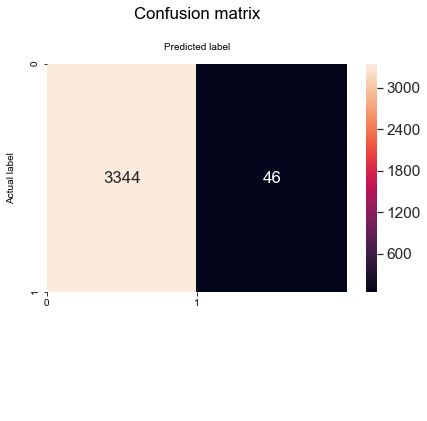

In [9]:
cm = confusion_matrix(y_test, predictGB) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
plt.show()

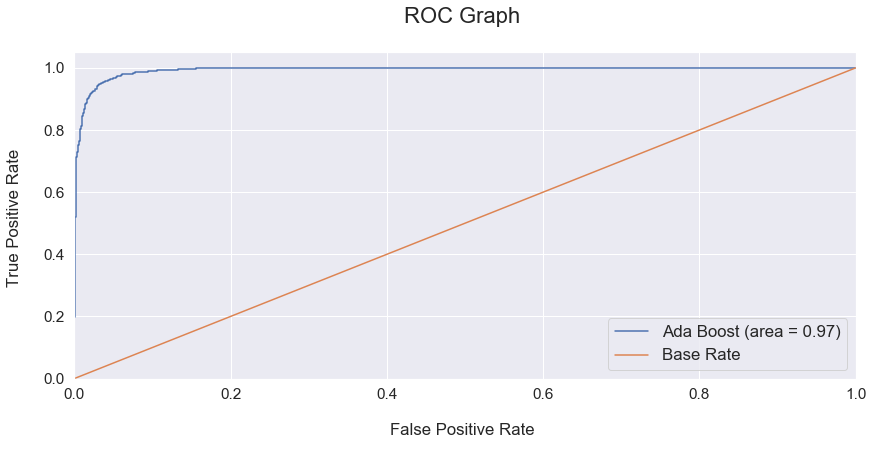

In [10]:
#get the ROC graph

probs = gb.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, predictGB )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Ada Boost ROC
plt.plot(rf_fpr, rf_tpr, label='Ada Boost (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

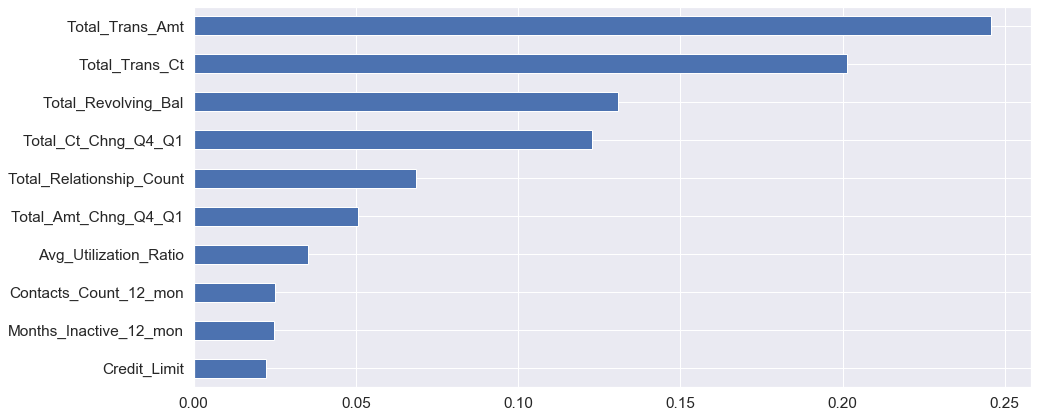

In [11]:
# get important features
plt.figure(figsize=(15,7))
feature_list = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_list.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.show()

### Further Exploration